In [3]:
#- Annotation manuelle et préparation des données

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
import pickle

# Charger les données
df = pd.read_csv("data_cleaned.csv")

# Fonction d'annotation manuelle assistée
def annotate_sentiment(text, keywords_positive, keywords_negative):
    """
    Annotation semi-automatique basée sur des mots-clés
    Vous devriez affiner cette logique selon vos observations
    """
    text_lower = text.lower()
    
    # Compter les mots positifs et négatifs
    pos_count = sum(1 for word in keywords_positive if word in text_lower)
    neg_count = sum(1 for word in keywords_negative if word in text_lower)
    
    if pos_count > neg_count:
        return 'positif'
    elif neg_count > pos_count:
        return 'négatif'
    else:
        return 'neutre'

# Définir des mots-clés (à affiner selon votre corpus)
keywords_positive = [
    'excellent', 'bon', 'bonne', 'super', 'bien', 'merci', 'félicitations',
    'bravo', 'génial', 'parfait', 'satisfait', 'qualité', 'succès',
    'réussite', 'compétent', 'professionnel', 'efficace'
]

keywords_negative = [
    'problème', 'mauvais', 'mauvaise', 'panne', 'bug', 'lent', 'cher',
    'difficile', 'compliqué', 'décevant', 'mécontentent', 'nul',
    'incompétent', 'arnaque', 'échec', 'frustrant'
]

# Annotation automatique
df['sentiment'] = df['Tweet'].apply(
    lambda x: annotate_sentiment(x, keywords_positive, keywords_negative)
)

# Afficher la distribution initiale
print("Distribution des sentiments (annotation automatique):")
print(df['sentiment'].value_counts())
print(f"\nPourcentages:")
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
for sentiment, pct in sentiment_counts.items():
    print(f"{sentiment}: {pct:.2f}%")

# Sauvegarder pour vérification manuelle
df.to_csv('data_with_sentiment.csv', index=False)
print("\n Données annotées sauvegardées dans 'data_with_sentiment.csv'")


Distribution des sentiments (annotation automatique):
sentiment
neutre     531
positif    245
négatif    124
Name: count, dtype: int64

Pourcentages:
neutre: 59.00%
positif: 27.22%
négatif: 13.78%

 Données annotées sauvegardées dans 'data_with_sentiment.csv'


In [4]:
#  Préparation des données pour l'entraînement

# Charger la matrice TF-IDF
X_tfidf = load_npz('tfidf_matrix.npz')

# Vérifier que nous avons le même nombre de lignes
assert X_tfidf.shape[0] == len(df), "Problème de correspondance entre matrice et labels"

# Encoder les labels
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# Mapping des labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping des labels:")
for label, code in label_mapping.items():
    print(f"  {label}: {code}")

# Division en ensembles d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTaille des ensembles:")
print(f"  Entraînement: {X_train.shape[0]} tweets")
print(f"  Test: {X_test.shape[0]} tweets")

print(f"\nDistribution dans l'ensemble d'entraînement:")
train_dist = pd.Series(y_train).value_counts()
for code, count in train_dist.items():
    label = le.inverse_transform([code])[0]
    print(f"  {label}: {count} ({count/len(y_train)*100:.1f}%)")

Mapping des labels:
  neutre: 0
  négatif: 1
  positif: 2

Taille des ensembles:
  Entraînement: 720 tweets
  Test: 180 tweets

Distribution dans l'ensemble d'entraînement:
  neutre: 425 (59.0%)
  positif: 196 (27.2%)
  négatif: 99 (13.8%)


In [5]:
#  Entraînement des modèles

from sklearn.metrics import precision_recall_fscore_support

# Dictionnaire pour stocker les résultats
results = {}
models = {}

# 1. Naive Bayes
print("="*60)
print("1. NAIVE BAYES")
print("="*60)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'predictions': y_pred_nb
}

print(classification_report(y_test, y_pred_nb, 
                          target_names=le.classes_))

# 2. Logistic Regression
print("\n" + "="*60)
print("2. LOGISTIC REGRESSION")
print("="*60)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'predictions': y_pred_lr
}

print(classification_report(y_test, y_pred_lr, 
                          target_names=le.classes_))

# 3. SVM
print("\n" + "="*60)
print("3. SUPPORT VECTOR MACHINE")
print("="*60)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

models['SVM'] = svm_model
results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'predictions': y_pred_svm
}

print(classification_report(y_test, y_pred_svm, 
                          target_names=le.classes_))

# Résumé comparatif
print("\n" + "="*60)
print("COMPARAISON DES MODÈLES")
print("="*60)
for model_name, result in results.items():
    print(f"{model_name}: {result['accuracy']*100:.2f}%")

1. NAIVE BAYES
              precision    recall  f1-score   support

      neutre       0.75      0.97      0.84       106
     négatif       1.00      0.44      0.61        25
     positif       0.90      0.57      0.70        49

    accuracy                           0.79       180
   macro avg       0.88      0.66      0.72       180
weighted avg       0.82      0.79      0.77       180


2. LOGISTIC REGRESSION
              precision    recall  f1-score   support

      neutre       0.77      0.99      0.87       106
     négatif       1.00      0.56      0.72        25
     positif       0.97      0.59      0.73        49

    accuracy                           0.82       180
   macro avg       0.91      0.71      0.77       180
weighted avg       0.86      0.82      0.81       180


3. SUPPORT VECTOR MACHINE
              precision    recall  f1-score   support

      neutre       0.86      0.97      0.91       106
     négatif       0.91      0.80      0.85        25
     posi

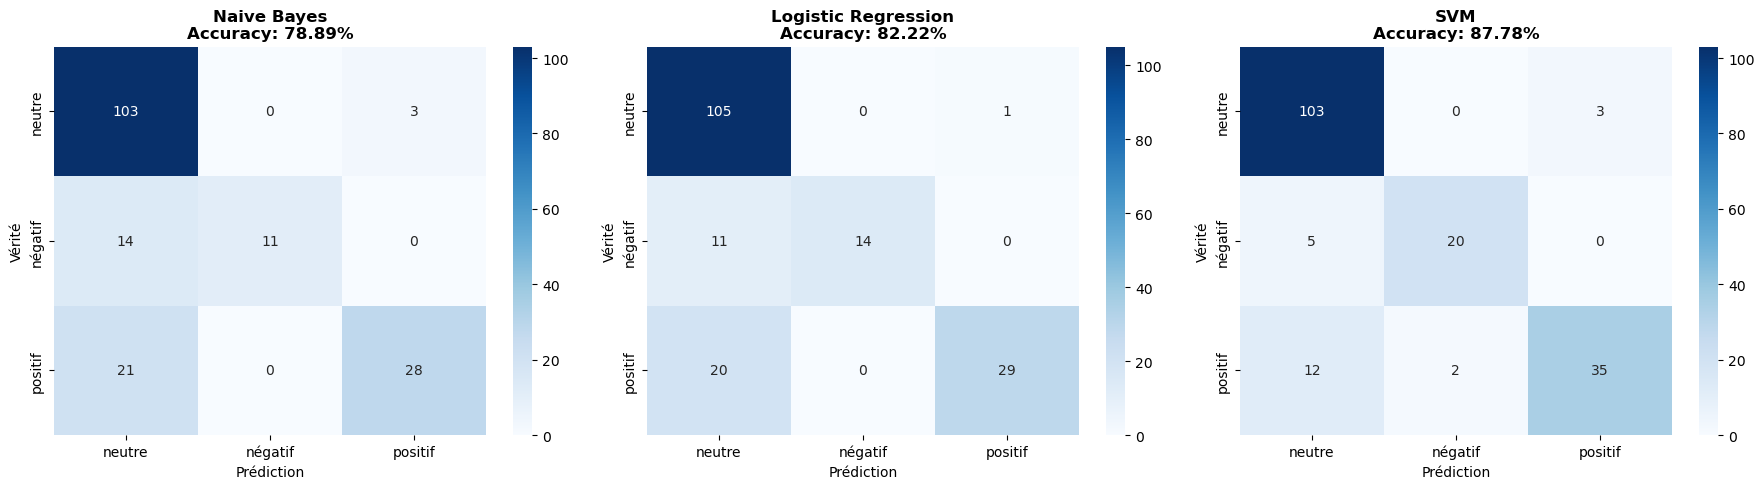

 Matrices de confusion sauvegardées


In [7]:
#  Visualisation des résultats

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, 
                yticklabels=le.classes_,
                ax=axes[idx])
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {result["accuracy"]*100:.2f}%',
                       fontweight='bold')
    axes[idx].set_xlabel('Prédiction')
    axes[idx].set_ylabel('Vérité')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Matrices de confusion sauvegardées")

Meilleur modèle: SVM
Accuracy: 87.78%

ANALYSE DE SENTIMENT SUR L'UVBF

Nombre de commentaires par sentiment:
  Neutre: 557 tweets (61.89%)
  Positif: 230 tweets (25.56%)
  Négatif: 113 tweets (12.56%)


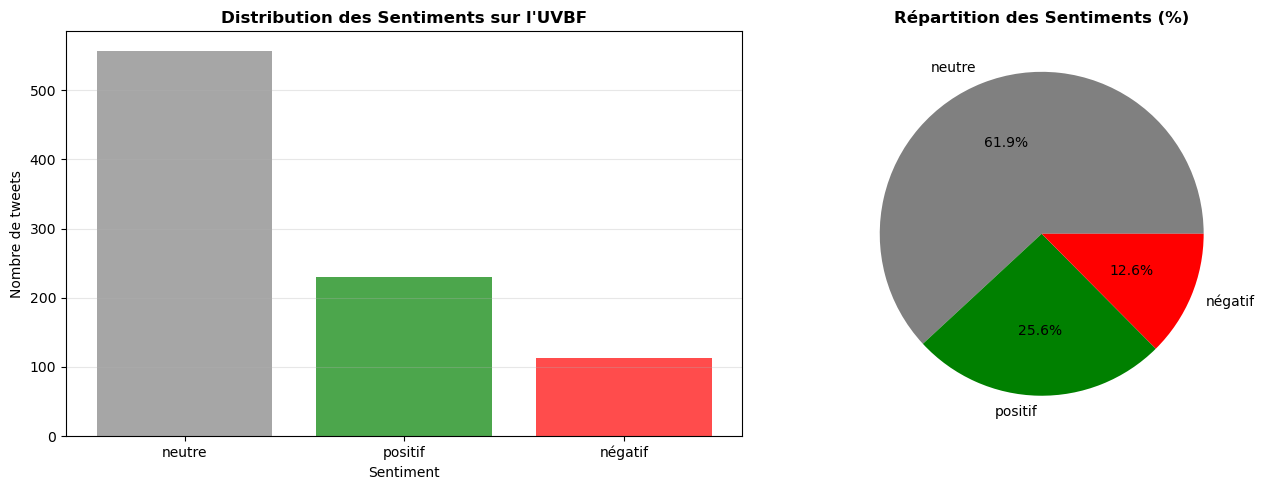


✓ Rapport sauvegardé dans 'rapport_sentiment_uvbf.csv'
✓ Graphiques sauvegardés dans 'sentiment_analysis_uvbf.png'
✓ Meilleur modèle (SVM) sauvegardé


In [8]:
#  Analyse des sentiments sur l'UVBF

# Prédire sur l'ensemble complet avec le meilleur modèle
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = models[best_model_name]

print(f"Meilleur modèle: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']*100:.2f}%\n")

# Prédire sur tous les tweets
all_predictions = best_model.predict(X_tfidf)
df['sentiment_predicted'] = le.inverse_transform(all_predictions)

# Statistiques finales
print("="*60)
print("ANALYSE DE SENTIMENT SUR L'UVBF")
print("="*60)

sentiment_dist = df['sentiment_predicted'].value_counts()
sentiment_pct = df['sentiment_predicted'].value_counts(normalize=True) * 100

print("\nNombre de commentaires par sentiment:")
for sentiment, count in sentiment_dist.items():
    pct = sentiment_pct[sentiment]
    print(f"  {sentiment.capitalize()}: {count} tweets ({pct:.2f}%)")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
colors = {'positif': 'green', 'neutre': 'gray', 'négatif': 'red'}
bar_colors = [colors[s] for s in sentiment_dist.index]

ax1.bar(sentiment_dist.index, sentiment_dist.values, color=bar_colors, alpha=0.7)
ax1.set_title('Distribution des Sentiments sur l\'UVBF', fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Nombre de tweets')
ax1.grid(axis='y', alpha=0.3)

# Camembert
ax2.pie(sentiment_pct.values, labels=sentiment_pct.index, autopct='%1.1f%%',
        colors=[colors[s] for s in sentiment_pct.index])
ax2.set_title('Répartition des Sentiments (%)', fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_analysis_uvbf.png', dpi=300, bbox_inches='tight')
plt.show()

# Sauvegarder le rapport final
report_df = pd.DataFrame({
    'Sentiment': sentiment_dist.index,
    'Nombre': sentiment_dist.values,
    'Pourcentage': sentiment_pct.values
})

report_df.to_csv('rapport_sentiment_uvbf.csv', index=False)

print("\nRapport sauvegardé dans 'rapport_sentiment_uvbf.csv'")
print(" Graphiques sauvegardés dans 'sentiment_analysis_uvbf.png'")

# Sauvegarder le meilleur modèle
with open('best_sentiment_model.pkl', 'wb') as f:
    pickle.dump({'model': best_model, 'encoder': le, 'name': best_model_name}, f)
    
print(f" Meilleur modèle ({best_model_name}) sauvegardé")